# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import yaml
import os
import random
import numpy as np
from pathlib import Path

# Load Configuration

In [2]:
config_path = "../configs/cam_config.yaml"  # Path to YAML config
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

# Set Random Seeds

In [3]:
torch.manual_seed(config["device"]["seed"])
np.random.seed(config["device"]["seed"])
random.seed(config["device"]["seed"])
if config["device"]["use_cuda"] and torch.cuda.is_available():
    torch.cuda.manual_seed_all(config["device"]["seed"])

# Check for CUDA

In [4]:
device = torch.device("cuda" if config["device"]["use_cuda"] and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Ensure output directories exist

In [5]:
Path(config["dataset"]["root_dir"]).mkdir(parents=True, exist_ok=True)
Path(config["outputs"]["results_dir"]).mkdir(parents=True, exist_ok=True)
Path(config["outputs"]["attention_maps_dir"]).mkdir(parents=True, exist_ok=True)

# Import the CAM Model

In [6]:
from utils.setup_path import add_project_root_to_path
add_project_root_to_path()

In [7]:
from CAM_Attention.scripts.cam_model import CAMModel

# Initialize the Model

In [8]:
model = CAMModel(num_classes=10).to(device)

# Define Loss and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"])

# Summary of the Model

In [10]:
print(model)

CAMModel(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=3, out_features=10, bias=True)
)


# Training Function

In [11]:
# Training Function
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * images.size(0)
    
    # Average loss over all batches
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


# Validation Function
def validate_one_epoch(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            running_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Average loss and accuracy
    epoch_loss = running_loss / len(test_loader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy


# Training Loop

Epoch [1/20] - Train Loss: 2.3607, Val Loss: 2.3467, Val Accuracy: 10.00%
Epoch [2/20] - Train Loss: 2.3070, Val Loss: 2.2570, Val Accuracy: 12.10%
Epoch [3/20] - Train Loss: 2.1930, Val Loss: 2.1267, Val Accuracy: 14.70%
Epoch [4/20] - Train Loss: 2.0568, Val Loss: 1.9941, Val Accuracy: 20.78%
Epoch [5/20] - Train Loss: 1.9307, Val Loss: 1.8841, Val Accuracy: 29.66%
Epoch [6/20] - Train Loss: 1.8273, Val Loss: 1.7948, Val Accuracy: 33.58%
Epoch [7/20] - Train Loss: 1.7458, Val Loss: 1.7301, Val Accuracy: 36.64%
Epoch [8/20] - Train Loss: 1.6782, Val Loss: 1.6695, Val Accuracy: 39.89%
Epoch [9/20] - Train Loss: 1.6189, Val Loss: 1.6105, Val Accuracy: 41.67%
Epoch [10/20] - Train Loss: 1.5666, Val Loss: 1.5612, Val Accuracy: 43.01%
Epoch [11/20] - Train Loss: 1.5237, Val Loss: 1.5249, Val Accuracy: 43.51%
Epoch [12/20] - Train Loss: 1.4876, Val Loss: 1.4928, Val Accuracy: 44.77%
Epoch [13/20] - Train Loss: 1.4541, Val Loss: 1.4538, Val Accuracy: 45.54%
Epoch [14/20] - Train Loss: 1.4219

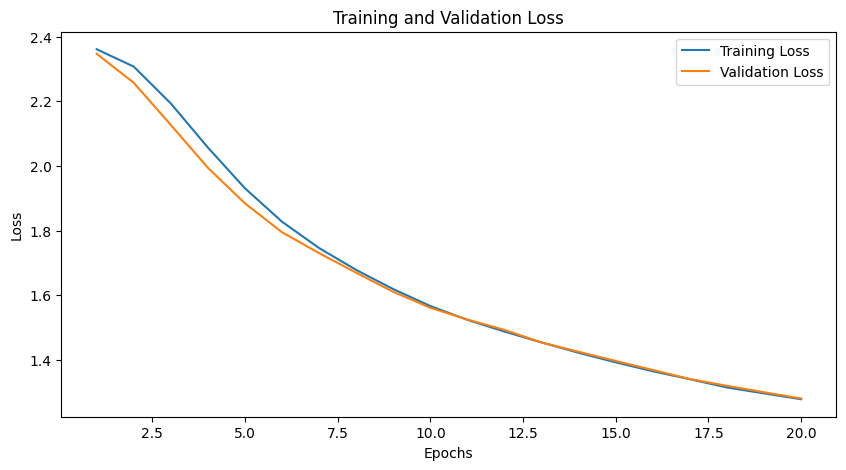

In [12]:
import matplotlib.pyplot as plt

# Get Data Loaders
from CAM_Attention.scripts.data_loader import get_data_loaders
train_loader, test_loader = get_data_loaders(config)

# Training Loop
num_epochs = config["training"]["num_epochs"]
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate_one_epoch(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy*100:.2f}%")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [13]:
# Save the Trained Model
model_save_path = os.path.join(config["outputs"]["results_dir"], "cam_model.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../outputs/cam_results\cam_model.pth


#  Evaluate Model Performance

Confusion Matrix:


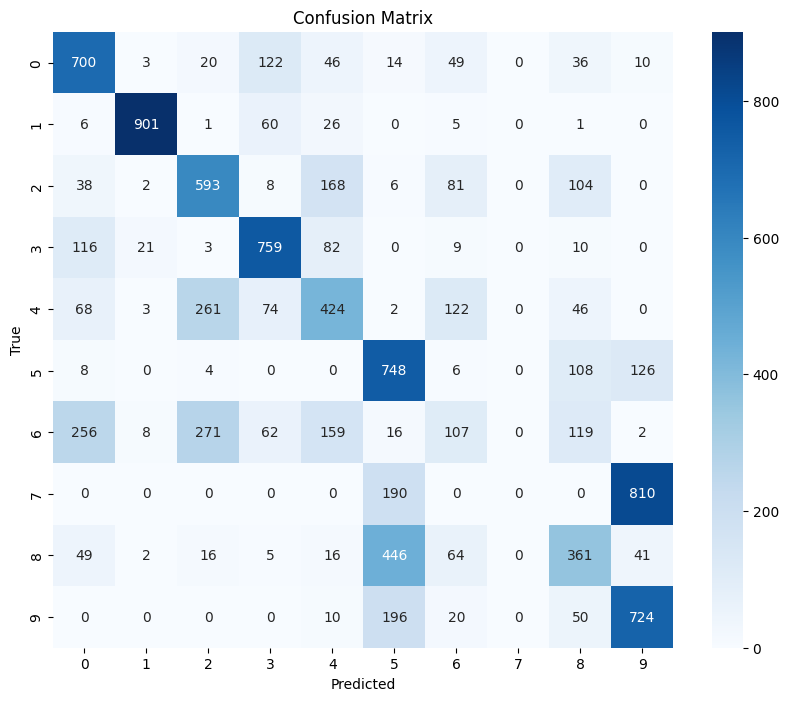

Weighted F1-Score: 0.4911


In [14]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Function to Evaluate the Model
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate Metrics
    conf_matrix = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return conf_matrix, f1

# Evaluate the Model
conf_matrix, f1 = evaluate_model(model, test_loader, device)

# Print Metrics
print("Confusion Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(f"Weighted F1-Score: {f1:.4f}")

# Generate Class Activation Maps (CAMs)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as F

# Hook to capture feature maps from the last convolutional layer
feature_maps = None

def hook_feature_maps(module, input, output):
    global feature_maps
    feature_maps = output.cpu().detach().numpy()  # Store feature maps
# Register the hook to the last convolutional layer
last_conv_layer = model.conv4
last_conv_layer.register_forward_hook(hook_feature_maps)

In [24]:
# Function to Generate Class Activation Map
def generate_cam(weights, class_idx):
    global feature_maps
    # Multiply feature maps by weights of the class and sum across channels
    cam = np.sum(feature_maps[0] * weights[class_idx, :, np.newaxis, np.newaxis], axis=0)
    cam = np.maximum(cam, 0)  # ReLU to remove negative values
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
    return cam

# Function to Visualize CAMs
def visualize_cam(input_image, cam, title):
    # Resize CAM to match input image size
    cam_resized = F.to_pil_image(torch.tensor(cam))
    cam_resized = cam_resized.resize(input_image.shape[1:], resample=Image.BICUBIC)

    # Overlay CAM on the input image
    plt.imshow(input_image.squeeze(0).cpu().numpy(), cmap="gray")
    plt.imshow(cam_resized, cmap="jet", alpha=0.5)  # CAM overlay
    plt.title(title)
    plt.axis("off")
    plt.show()

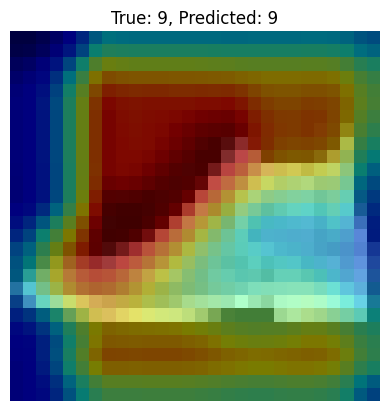

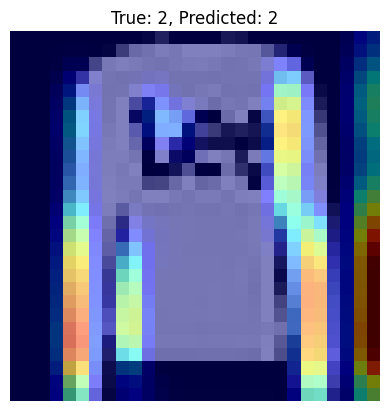

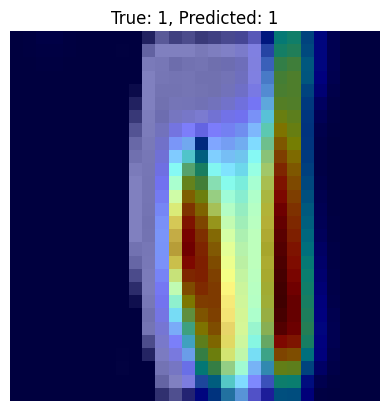

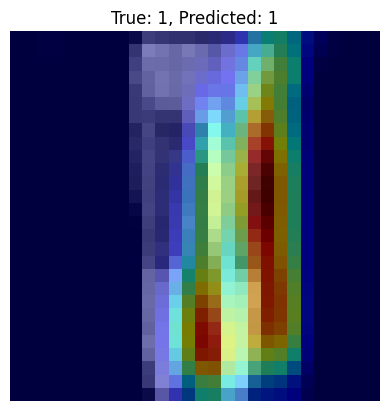

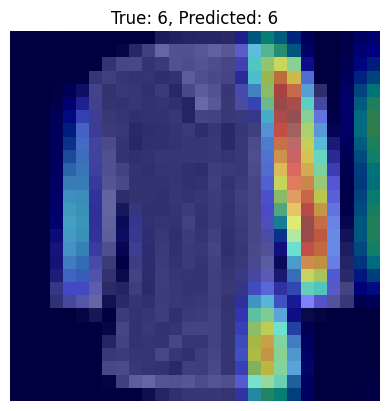

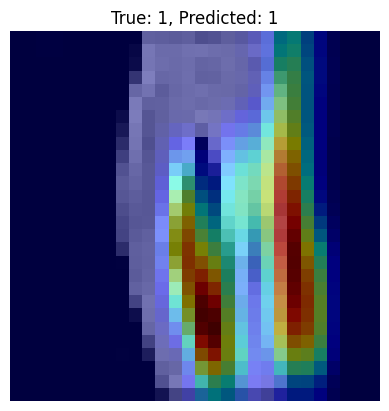

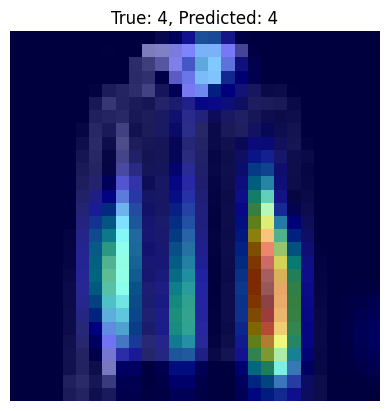

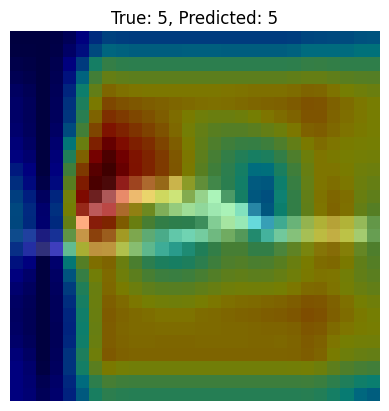

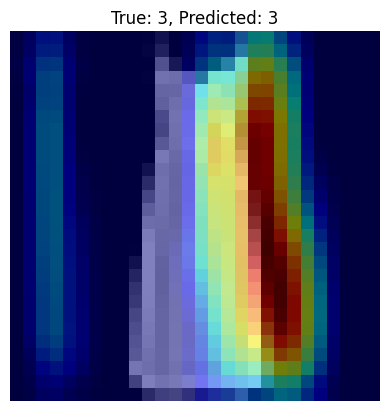

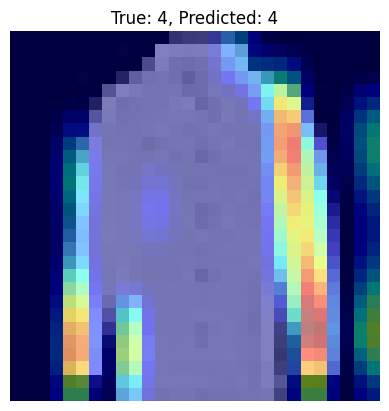

In [25]:
# Visualize Correctly Classified Examples
correct_samples = 10
correct_data = []

# Collect Correct Predictions
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if predicted[i] == labels[i] and len(correct_data) < correct_samples:
                correct_data.append((images[i], labels[i], predicted[i]))
            if len(correct_data) >= correct_samples:
                break

# Visualize CAMs
for image, label, prediction in correct_data:
    # Perform a forward pass to capture feature maps
    _ = model(image.unsqueeze(0))  # Single image batch

    # Get weights of the fully connected layer
    fc_weights = model.fc.weight.cpu().detach().numpy()

    # Generate CAM
    cam = generate_cam(fc_weights, prediction.item())

    # Show CAM
    visualize_cam(image, cam, f"True: {label.item()}, Predicted: {prediction.item()}")

True: 6, Predicted: 2


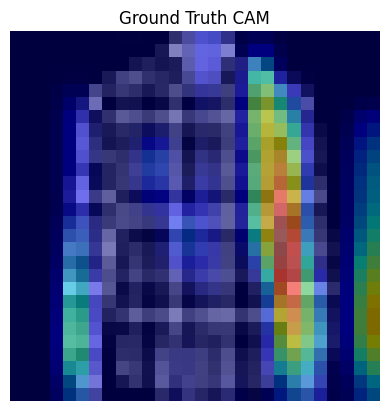

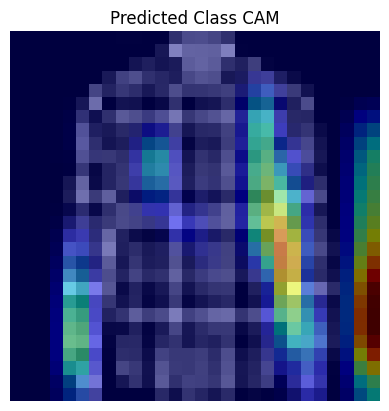

True: 7, Predicted: 9


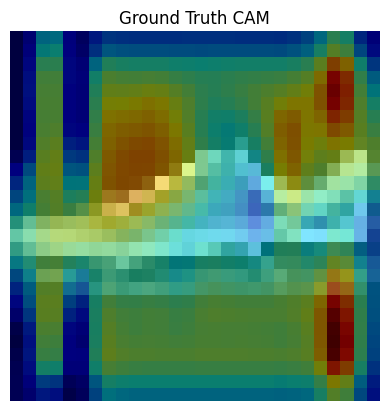

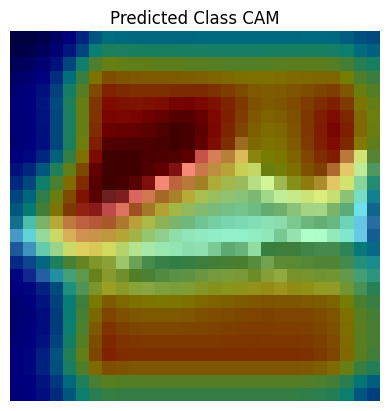

True: 4, Predicted: 2


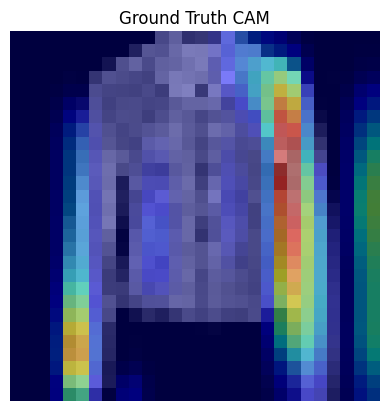

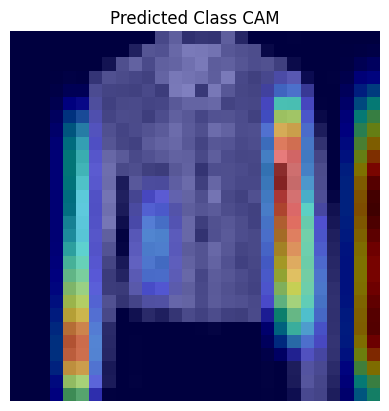

True: 5, Predicted: 8


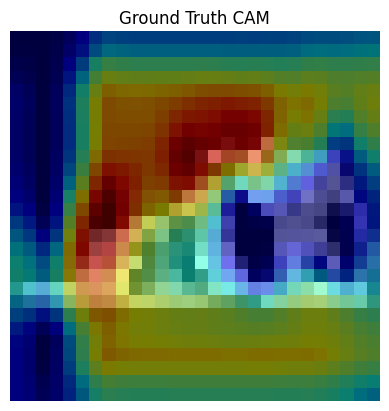

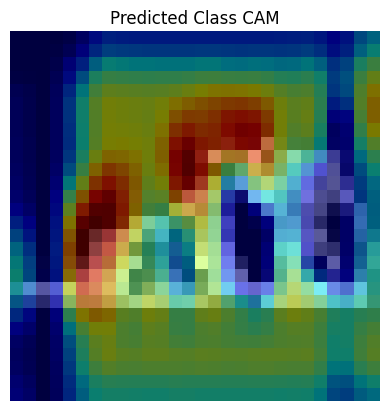

True: 7, Predicted: 9


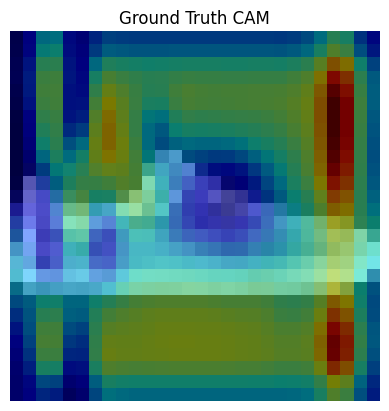

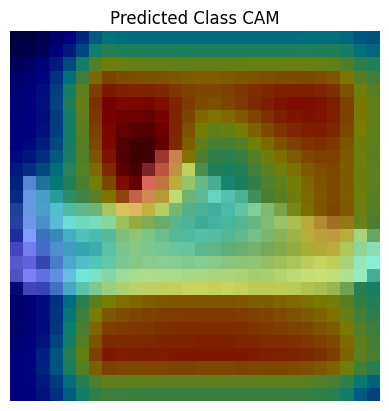

True: 4, Predicted: 2


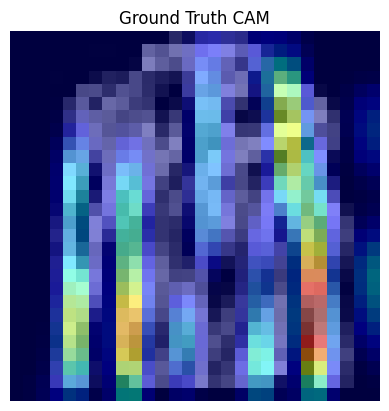

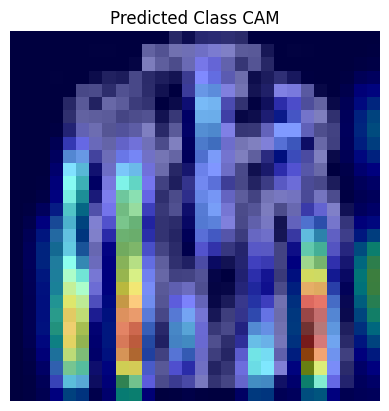

True: 8, Predicted: 5


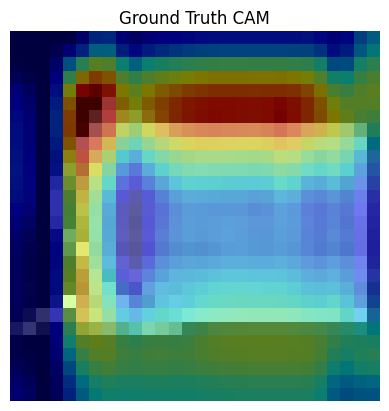

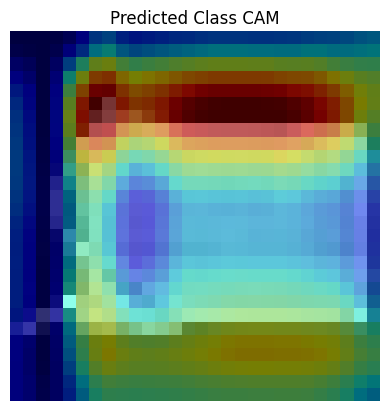

True: 5, Predicted: 9


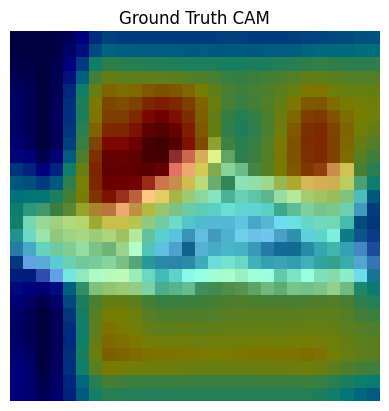

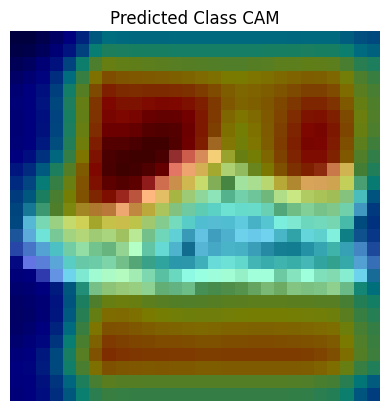

True: 7, Predicted: 9


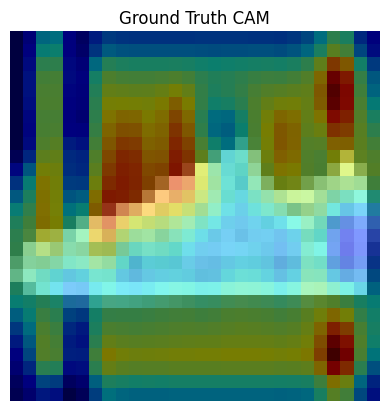

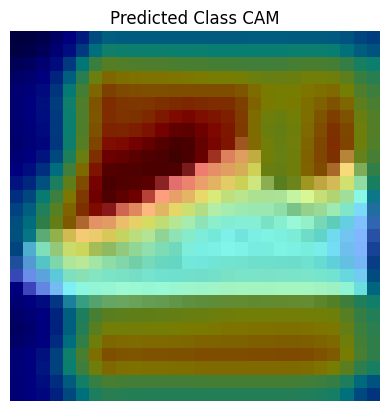

True: 4, Predicted: 8


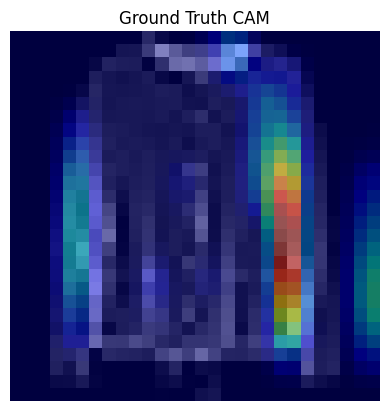

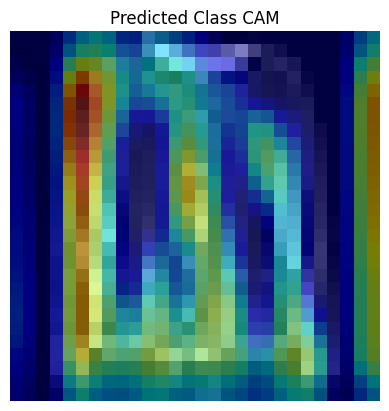

True: 6, Predicted: 2


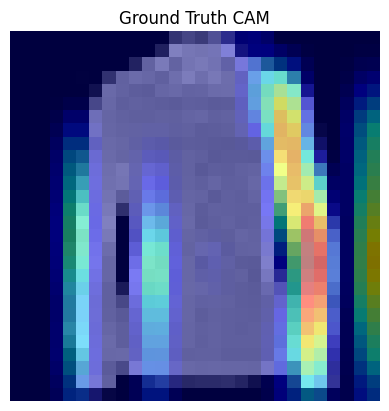

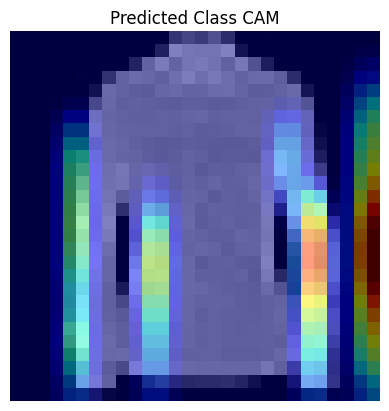

True: 7, Predicted: 9


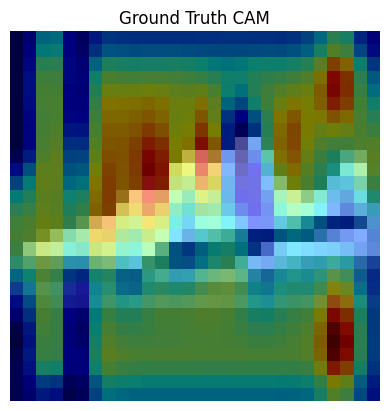

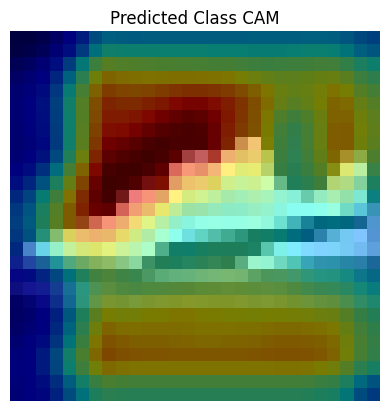

True: 5, Predicted: 9


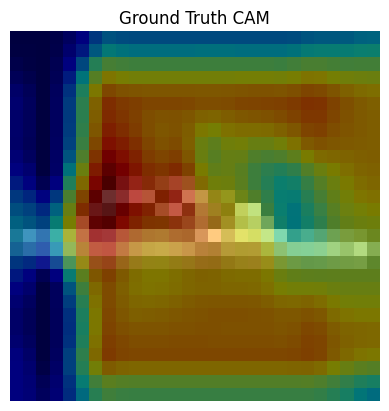

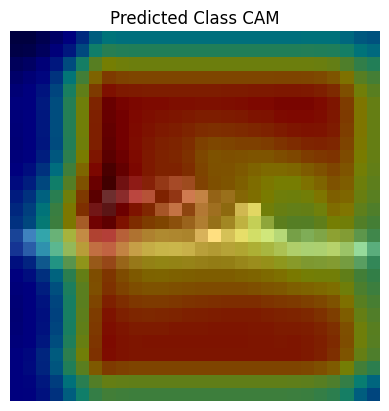

True: 7, Predicted: 9


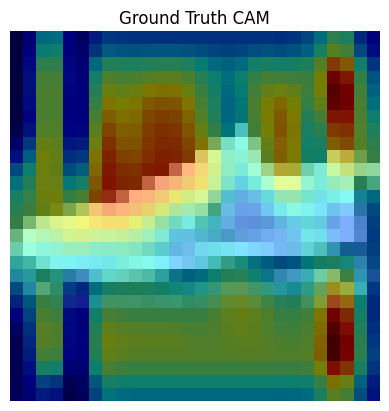

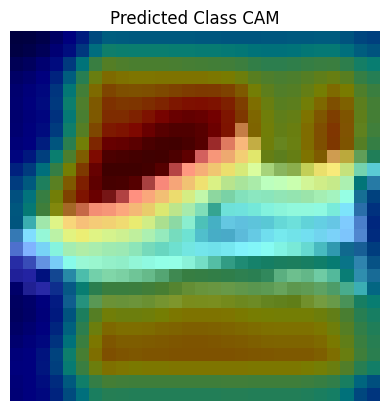

True: 6, Predicted: 0


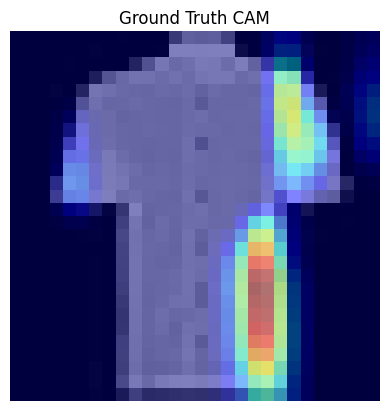

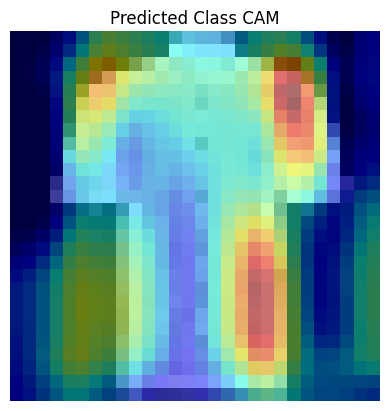

True: 7, Predicted: 9


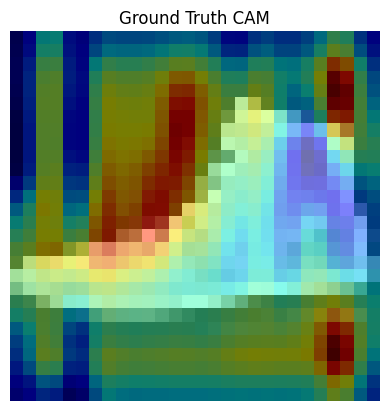

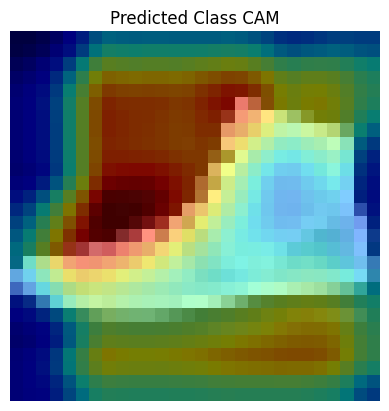

True: 6, Predicted: 4


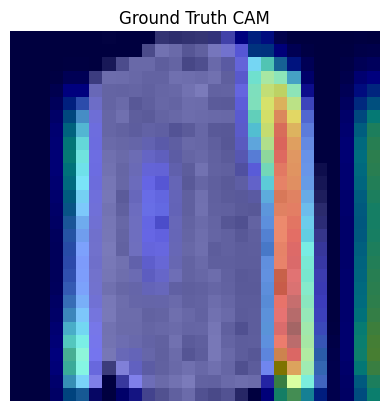

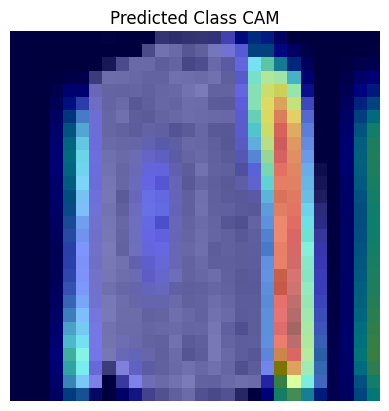

True: 7, Predicted: 9


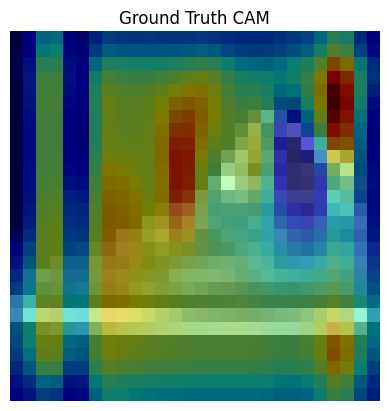

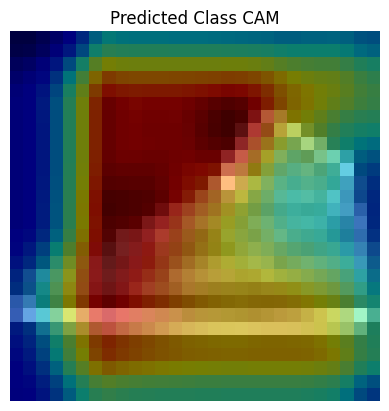

True: 2, Predicted: 6


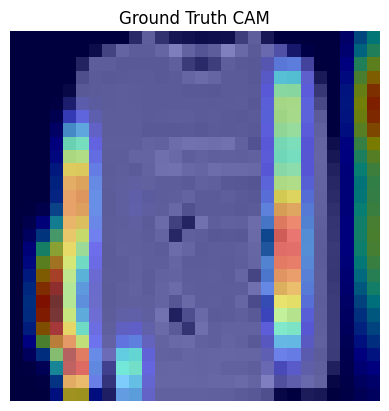

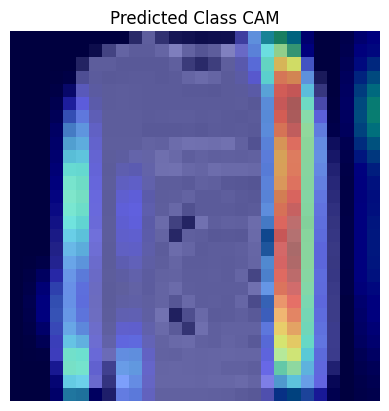

True: 2, Predicted: 4


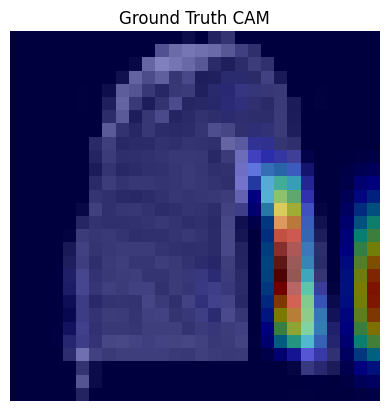

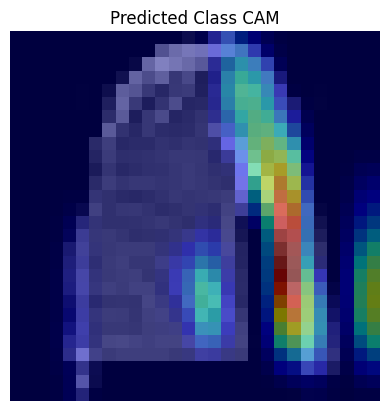

True: 2, Predicted: 4


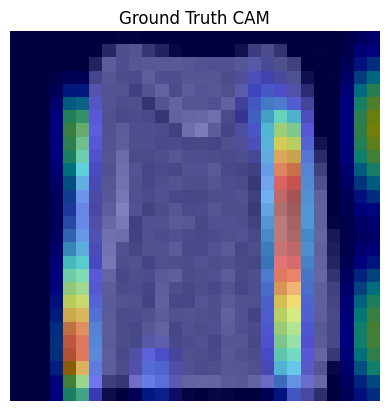

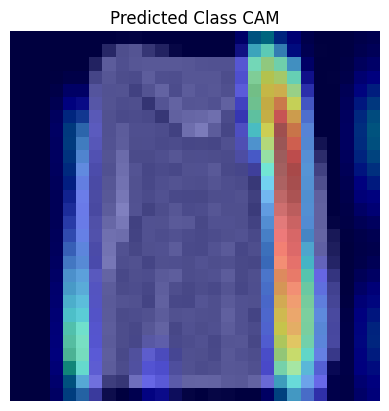

True: 4, Predicted: 2


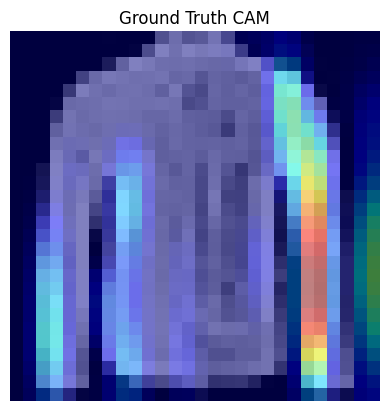

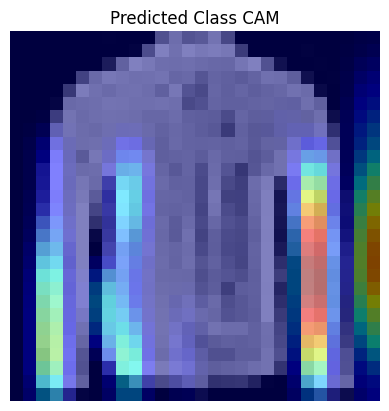

True: 4, Predicted: 8


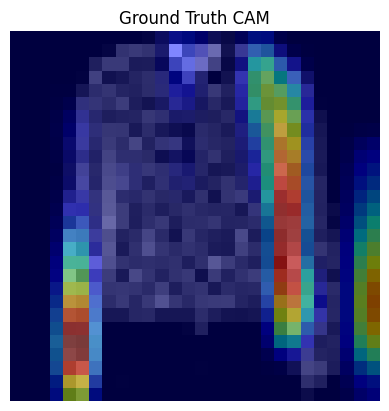

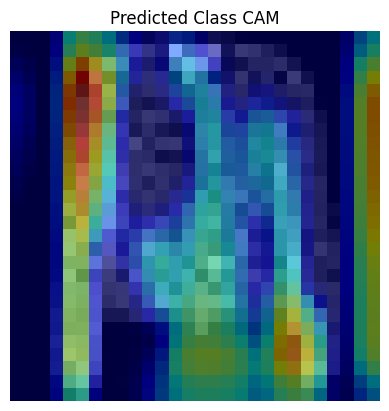

True: 8, Predicted: 5


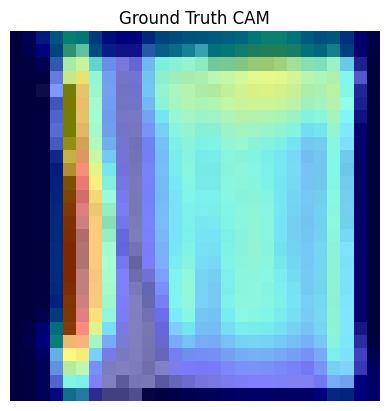

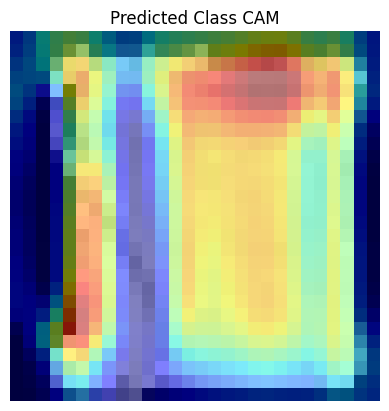

True: 2, Predicted: 4


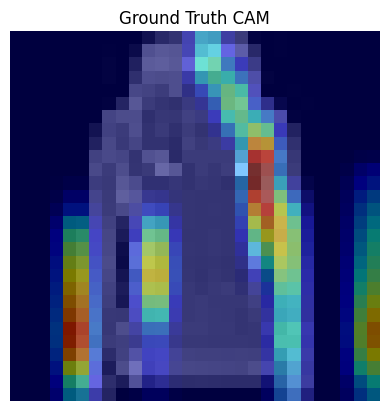

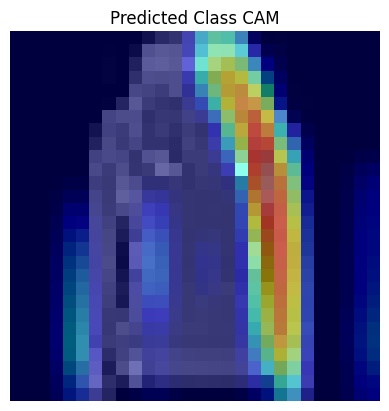

True: 8, Predicted: 5


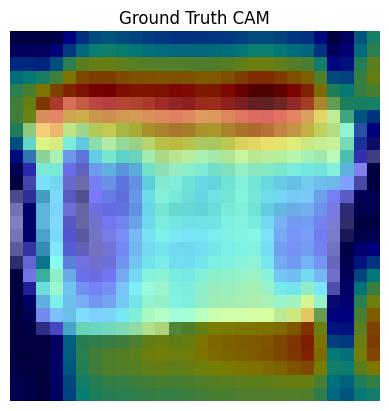

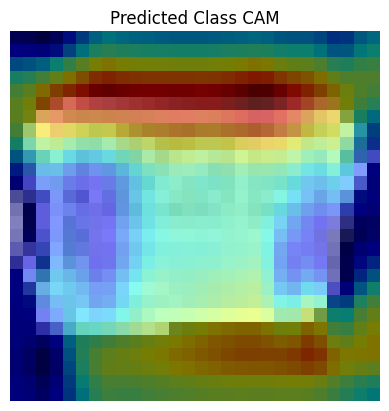

True: 4, Predicted: 2


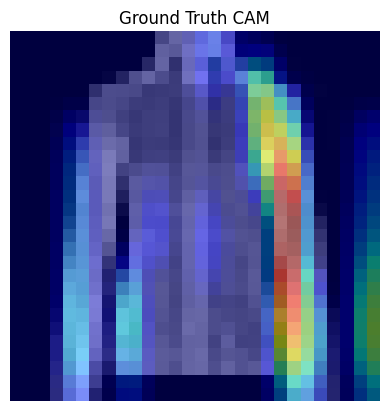

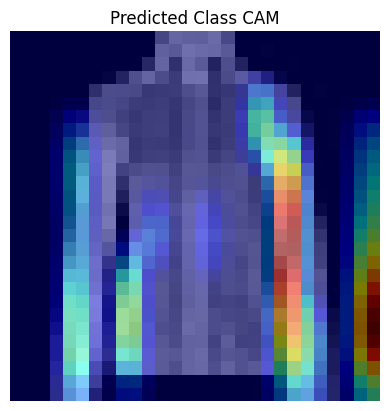

True: 8, Predicted: 5


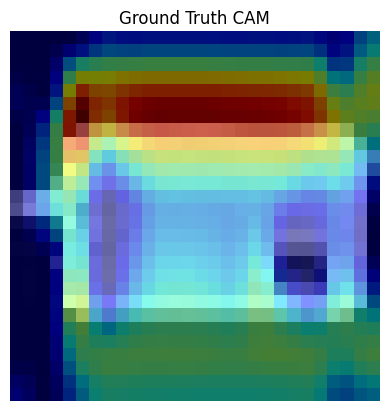

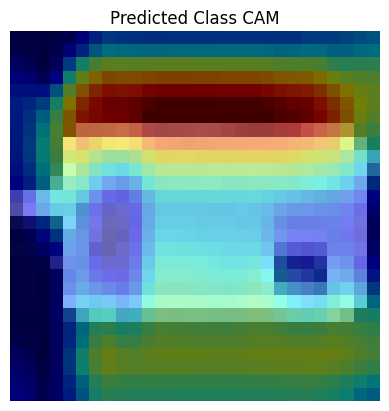

True: 7, Predicted: 9


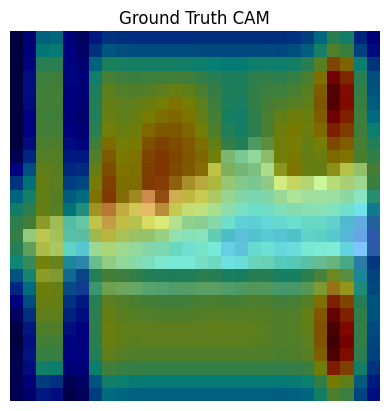

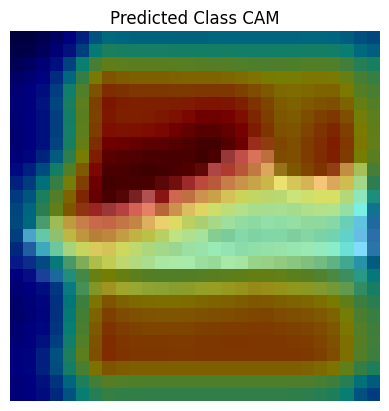

True: 7, Predicted: 9


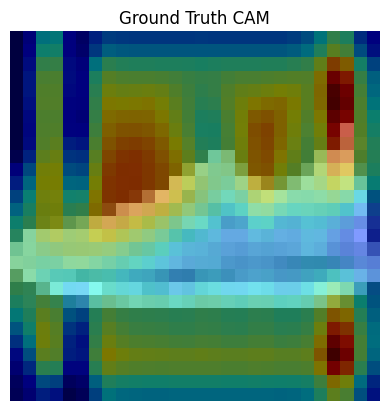

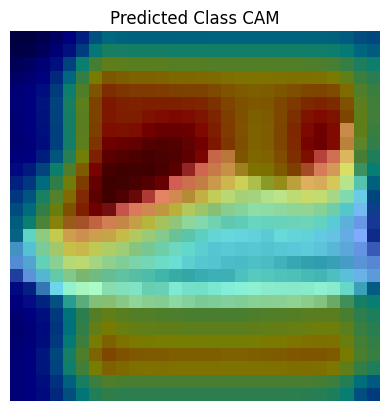

In [26]:
# Visualize Incorrectly Classified Examples
incorrect_samples = 30
incorrect_data = []

# Collect Incorrect Predictions
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if predicted[i] != labels[i] and len(incorrect_data) < incorrect_samples:
                incorrect_data.append((images[i], labels[i], predicted[i]))
            if len(incorrect_data) >= incorrect_samples:
                break

# Visualize CAMs for Incorrect Predictions
for image, label, prediction in incorrect_data:
    # Perform a forward pass to capture feature maps
    _ = model(image.unsqueeze(0))  # Single image batch

    # Get weights of the fully connected layer
    fc_weights = model.fc.weight.cpu().detach().numpy()

    # Generate CAMs for True and Predicted Class
    cam_true = generate_cam(fc_weights, label.item())
    cam_pred = generate_cam(fc_weights, prediction.item())

    # Show CAMs
    print(f"True: {label.item()}, Predicted: {prediction.item()}")
    visualize_cam(image, cam_true, "Ground Truth CAM")
    visualize_cam(image, cam_pred, "Predicted Class CAM")